In [37]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from pathlib import Path

In [3]:
from fastai import *
from fastai.vision import *
from fastai.vision.data import ObjectCategoryProcessor   
from fastai.layers import *
from fastai.callbacks.hooks import num_features_model
from fastai.callbacks.mixup import *     
from torch.nn import L1Loss

In [8]:
path = Path('/data/Datasets/WhiteBloodCancer/train/')

In [9]:
images, lbl_bbox = get_annotations(path/'WhiteBloodCellCoco.json')
img2bbox = dict(zip(images, lbl_bbox))
get_y_func = lambda o:img2bbox[o.name]

In [4]:
class BloodCellObjectCategoryProcessor(ObjectCategoryProcessor):               
                                                                               
    def generate_classes(self, items):                                         
        "Generate classes from `items` by taking the sorted unique values."    
        classes = set()                                                        
        for c in items: classes = classes.union(set(c[1]))                     
        classes = list(classes)                                                
        classes.sort()                                                         
        return classes                                                         

In [42]:
class BloodCellObjectCategoryList(ObjectCategoryList):
    _processor = BloodCellObjectCategoryProcessor           
    
    def analyze_pred(self, pred):
        return [pred[0], pred[1].max(0)[1]]
    
    def reconstruct(self, t, x):
        (bboxes, labels) = t
        #if len((labels - self.pad_idx).nonzero()) == 0: return
        if labels.ndim == 0: labels = labels.view(-1)
        i = 0#(labels - self.pad_idx).nonzero().min()
        bboxes,labels = bboxes[i:],labels[i:]
        return ImageBBox.create(*x.size, bboxes, labels=labels, classes=self.classes, scale=False)

In [43]:
data = (ObjectItemList.from_folder(path, extensions='.bmp')
        #Where are the images? -> in coco
        .random_split_by_pct()
        #How to split in train/valid? -> randomly with the default 20% in valid
        .label_from_func(get_y_func, label_cls=BloodCellObjectCategoryList)
        #How to find the labels? -> use get_y_func
        .transform(get_transforms(), tfm_y=True, size=256)
        #Data augmentation? -> Standard transforms with tfm_y=True
        .databunch(bs=16, collate_fn=bb_pad_collate))
        #Finally we convert to a DataBunch and we use bb_pad_collate

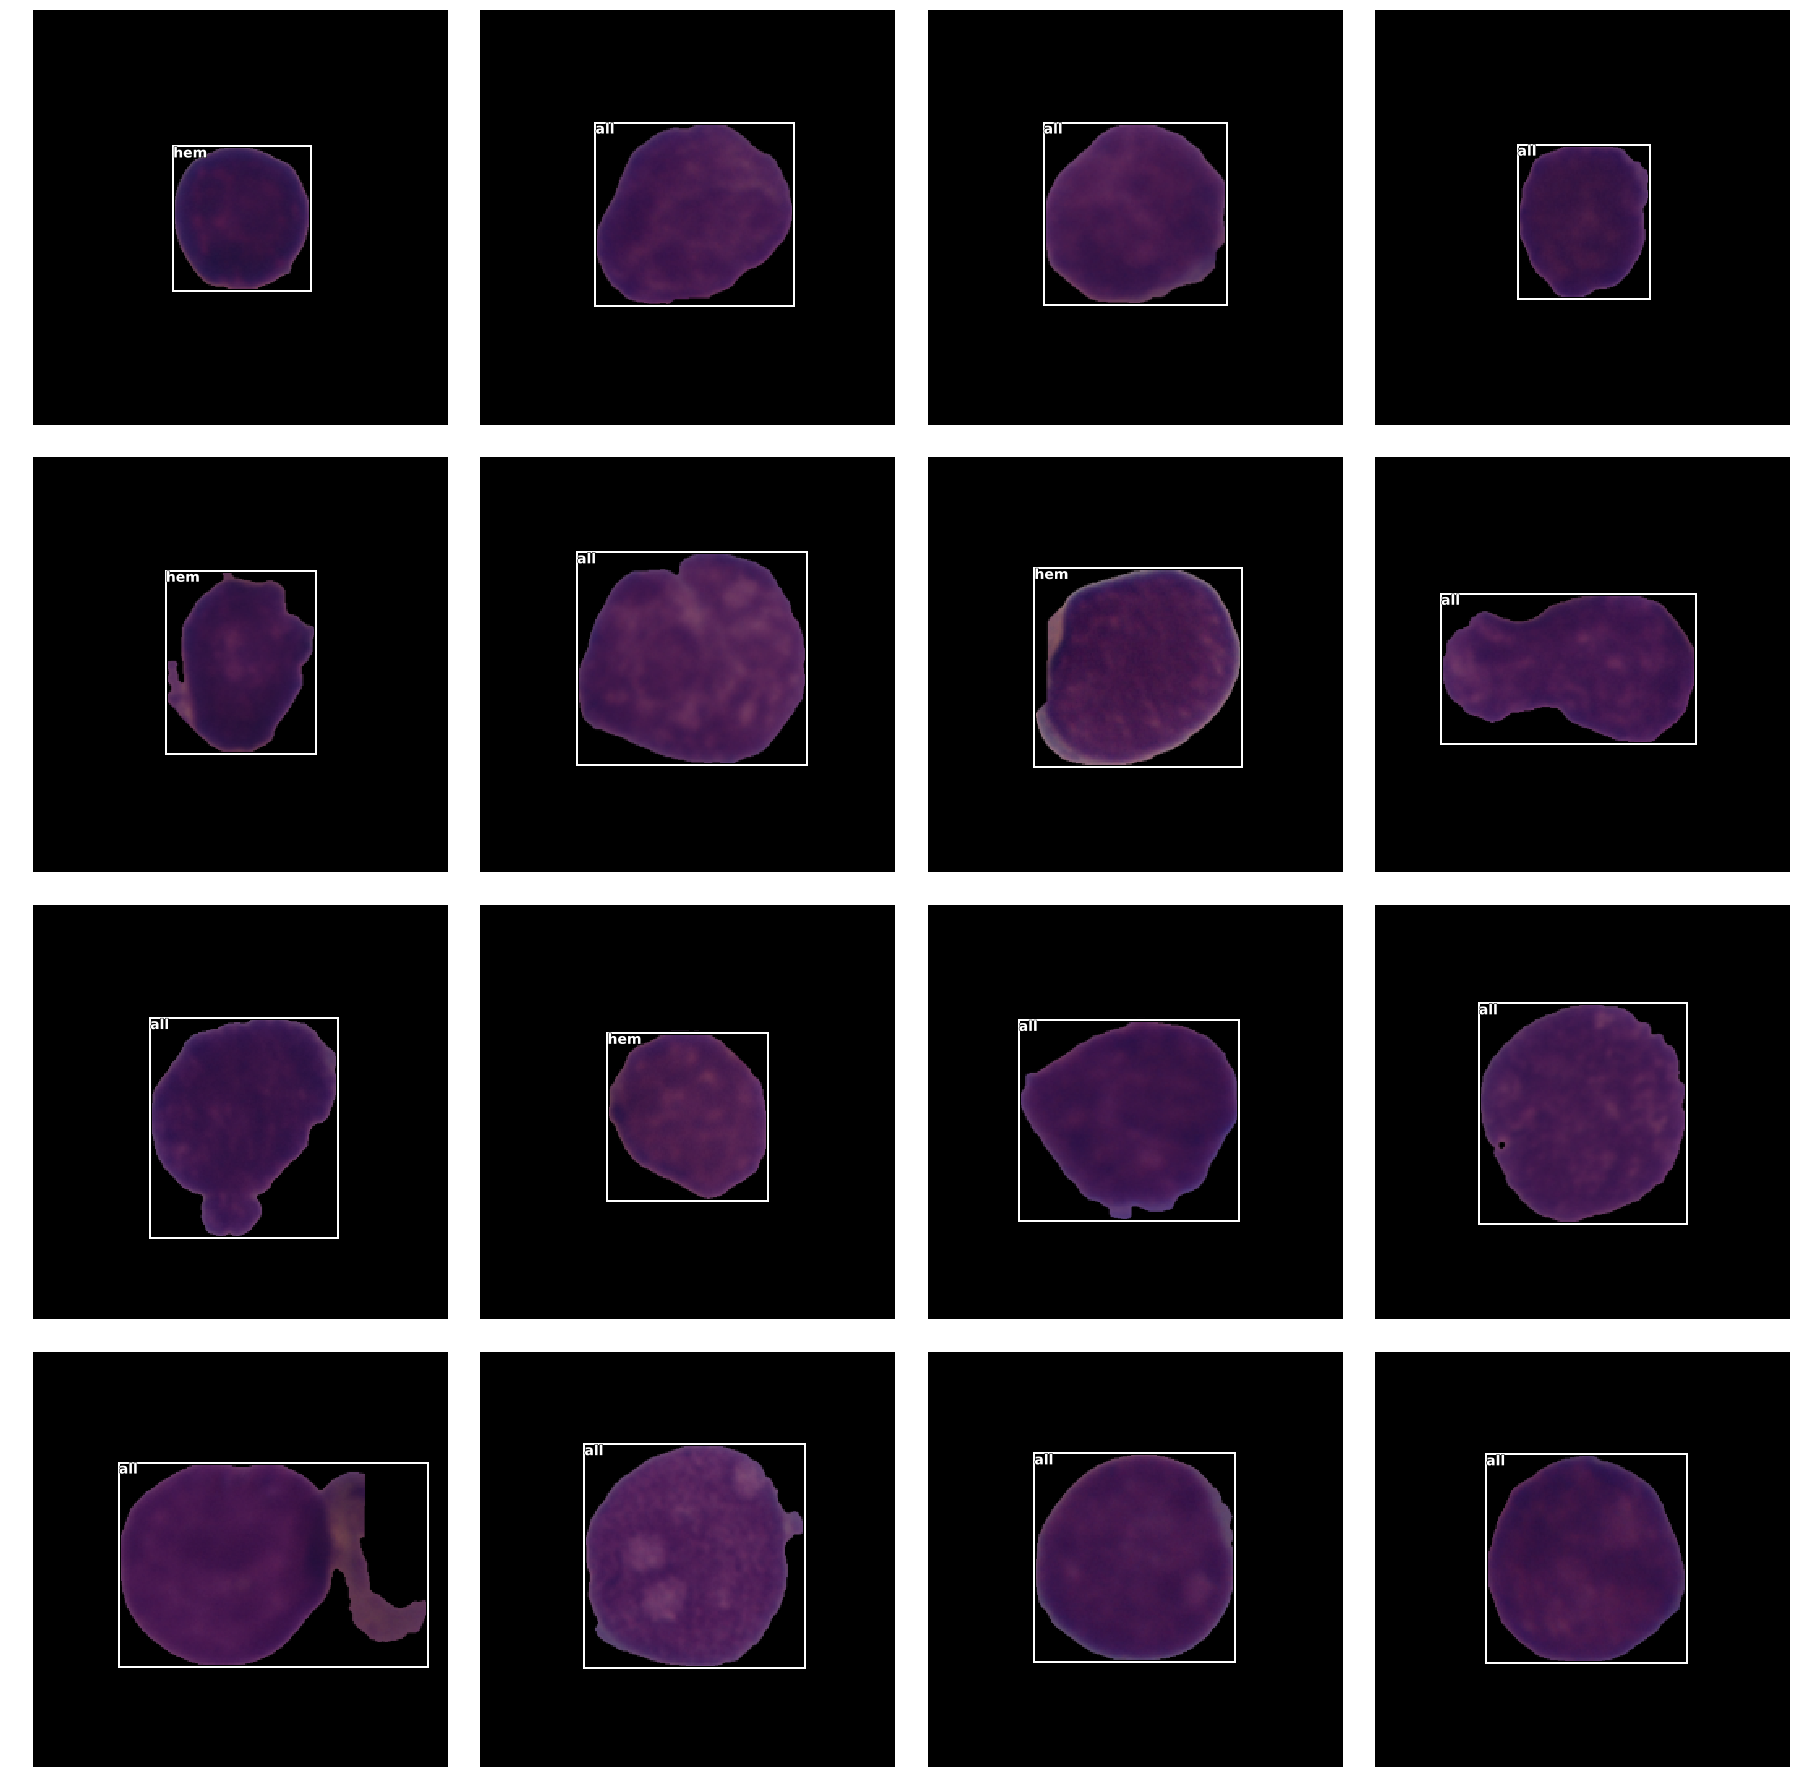

In [44]:
data.show_batch(rows=4, ds_type=DatasetType.Valid, figsize=(25,25))

In [45]:
class CellFinder(nn.Module):
    def __init__(self, arch=models.resnet18):
        super().__init__()
        self.cnn = create_body(arch)
        self.box_regressor = create_head(num_features_model(self.cnn) * 2, 4)
        self.classifier = create_head(num_features_model(self.cnn) * 2, 2)

    def forward(self, im):
        x = self.cnn(im)
        box = self.box_regressor(x)
        classifier = self.classifier(x)

        return [(2 * (box.sigmoid_() - 0.5)).view(-1, 1, 4), classifier]

In [46]:
class BBMixUpCallback(MixUpCallback):                                                                             
                                                                                                                  
    def on_batch_begin(self, last_input, last_target, train, **kwargs):                                           
        "Applies mixup to the `last_input` boxes and `last_target` boxes if `train`."                             
        lambd = np.random.beta(self.alpha, self.alpha, last_target[0].size(0))                                    
        lambd = np.concatenate([lambd[:,None], 1-lambd[:,None]], 1).max(1)                                        
        lambd = last_input.new(lambd)                                                                             
        shuffle = torch.randperm(last_target[0].size(0)).to(last_input.device)                                    
        x1, y1 = last_input[shuffle], [last_target[0][shuffle], last_target[1][shuffle]]                          
        if self.stack_x:                                                                                          
            raise NotImplementedError                                                                             
        else:                                                                                                     
            new_input = (last_input * lambd.view(lambd.size(0), 1, 1, 1))#.permute(0,2,3,1)                       
            new_x = (x1 * (1-lambd).view(lambd.size(0), 1, 1, 1))#.permute(0,2,3,1)                               
            h, w = new_input.shape[2:4]                                                                           
                                                                                                                  
            x1_boxes = y1[0].add(1).mul(torch.tensor([h / 2, w / 2, h / 2, w / 2])
                                        .to(last_input.device)).long().squeeze()                                                     
                                                                                                                  
            new_input_boxes = last_target[0].add(1).mul(torch.tensor([h / 2, w / 2, h / 2, w / 2])
                                                        .to(last_input.device)).long().squeeze()                                                     
                                                                                                                  
            for i in range(last_target[0].size(0)):                                                               
                n_box, x1_box = new_input_boxes[0], x1_boxes[0]                                                   
                new_input[i, :, n_box[0]:n_box[2], n_box[1]:n_box[3]] += F.interpolate(new_x[i, :, x1_box[0]:x1_box[2], x1_box[1]:x1_box[3]][None],(n_box[2]-n_box[0],n_box[3]-n_box[1]))[0]                                         
        if self.stack_y:                                                                                          
            last_target[1] = torch.cat([last_target[1][:, None].float(),                                          
                                        y1[1][:, None].float(),                                                   
                                        lambd[:, None, None].float()], 1).squeeze()                               
        else:                                                                                                     
            raise NotImplementedError                                                                             
        return (new_input, last_target)                                                                           

In [47]:
class BBCombinedMixUpLoss(nn.Module):                                                                  
                                                                                                       
    def __init__(self, bb_scale_factor: int=1):                                                        
        super().__init__()                                                                             
                                                                                                       
        self.classification_loss = None                                                                
        self.BBloss = None                                                                             
        self.bb_scale_factor = bb_scale_factor                                                         
                                                                                                       
    def forward(self, output, bbox, clas, reduction='elementwise_mean'):                               
        bbox_preds, clas_preds = output                                                                
        bbox_tgts = bbox                                                                               
        clas_tgts = clas                                                                               
                                                                                                       
        self.BBloss = L1Loss()(bbox_preds, bbox_tgts.squeeze())                                        
        loss1 = CrossEntropyFlat()(clas_preds, clas_tgts[:, 0].long()) 
        loss2 = CrossEntropyFlat()(clas_preds, clas_tgts[:, 1].long())                          
                                                                                                       
        d = (loss1 * clas_tgts[:, 2] + loss2 * (1 - clas_tgts[:, 2])).mean()                           
        if reduction == 'elementwise_mean':                                                            
            d = d.mean()                                                                               
        elif reduction == 'sum':                                                                       
            d = d.sum_()                                                                               
        self.classification_loss = d                                                                   
                                                                                                       
        return self.BBloss * self.bb_scale_factor + self.classification_loss                           

In [48]:
class HandleDualLoss(LearnerCallback):                                                         
    _order = -20  # Needs to run before the recorder                                           
                                                                                               
    def on_train_begin(self, **kwargs):                                                        
        self.learn.recorder.add_metric_names(['bb_loss', 'c_loss'])                            
                                                                                               
    def on_epoch_begin(self, **kwargs):                                                        
        self.bb_loss, self.c_loss, self.nums = 0., 0., 0                                       
                                                                                               
    def on_batch_end(self, last_target, train, **kwargs):                                      
        if not train:                                                                          
            bs = last_target[0].size(0)                                                        
            self.bb_loss += bs * learn.loss_func.BBloss.detach()                               
            self.c_loss += bs * learn.loss_func.classification_loss.detach()                   
            self.nums += bs                                                                    
                                                                                               
    def on_epoch_end(self, **kwargs):                                                          
        self.learn.recorder.add_metrics([self.bb_loss / self.nums, self.c_loss / self.nums])   

In [57]:
def iou_metric(output, bbox_tgts, clas_tgts):
    clas_preds, bbox_preds = output
    return dice(bbox_tgts.squeeze(), bbox_preds.long()).item()

In [49]:
learn = Learner(data, CellFinder(arch=models.resnet18), loss_func=BBCombinedMixUpLoss(), 
                callback_fns=[HandleDualLoss, BBMixUpCallback])                                 
#learn.metrics = [iou_metric]

learn.split([learn.model.cnn[:6], learn.model.cnn[6:], learn.model.box_regressor, learn.model.classifier])

In [50]:
learn.freeze_to(-2)

In [51]:
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,bb_loss,c_loss
1,0.667076,0.597150,0.071107,0.526043
2,0.595725,0.519909,0.079139,0.440769
3,0.566586,0.498791,0.079063,0.419729
4,0.522837,0.507058,0.088729,0.418329
5,0.535789,0.475546,0.073527,0.402018


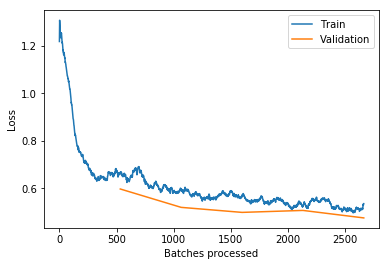

In [52]:
learn.recorder.plot_losses()

In [56]:
learn.unfreeze()

In [57]:
max_lr = 2e-3
lrs = [max_lr/100, max_lr/10, max_lr, max_lr]

In [58]:
learn.fit_one_cycle(5, lrs, div_factor=20)

epoch,train_loss,valid_loss,bb_loss,c_loss
1,0.533282,0.485078,0.072580,0.412498
2,0.541520,0.468610,0.069732,0.398878
3,0.534373,0.488847,0.073622,0.415225
4,0.518234,0.454755,0.074276,0.380479
5,0.498568,0.460176,0.076083,0.384094


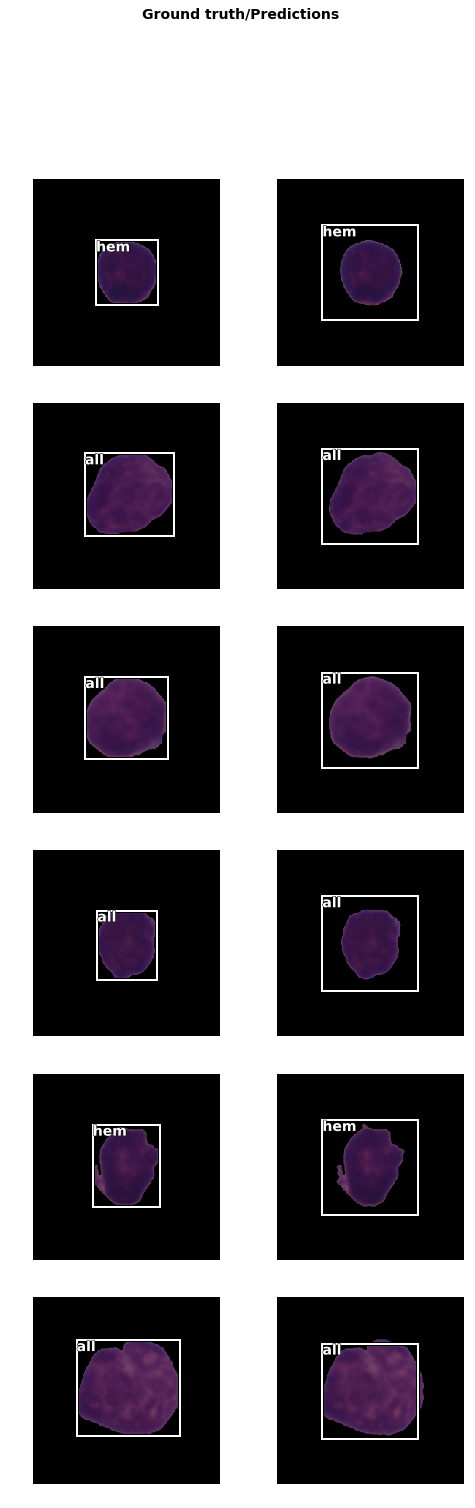

In [59]:
learn.show_results(rows=6, ds_type=DatasetType.Valid)